<a href="https://colab.research.google.com/github/yagmurakarken/Sprites/blob/master/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Most of the code is taken from COMP447 HW question. The code is adapted for Sprites dataset.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/johnberg1/deepul.git
!git clone https://github.com/yagmurakarken/Sprites.git
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 238, done.
remote: Total 238 (delta 0), reused 0 (delta 0), pack-reused 238
Receiving objects: 100% (238/238), 60.56 MiB | 37.81 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Cloning into 'Sprites'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 68 (delta 1), reused 2 (delta 0), pack-reused 59
Unpacking objects: 100% (68/68), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./deepul
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issu

In [2]:
from deepul.hw2_helper import *

In [3]:
import deepul.pytorch_util as ptu
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import trange, tqdm_notebook
import copy
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from scipy.stats import norm

In [4]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

In [5]:
def train(model, train_loader, optimizer, epoch, quiet, grad_clip=None, prior=False):
    model.train()

    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x in train_loader:
        x = x.cuda()
        if not prior:
          x = x.float()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'

        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return losses


def eval_loss(model, data_loader, quiet, prior):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            if not prior:
              x = x.float()
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses


def train_epochs(model, train_loader, test_loader, train_args, quiet=False, prior=False):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = OrderedDict(), OrderedDict()
    for epoch in range(epochs):
        model.train()
        train_loss = train(model, train_loader, optimizer, epoch, quiet, grad_clip, prior=prior)
        test_loss = eval_loss(model, test_loader, quiet, prior=prior)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses

In [6]:
%cd Sprites
!python random_character.py
!python frame_to_npy.py
!rm -rf frames/
%cd ..

from Sprites.load_sprites import sprites_act
X_train, X_test, A_train, A_test, D_train, D_test = sprites_act('Sprites/', return_labels=True)

/content/Sprites
saved npy/walk_front_frames_train.npy
saved npy/walk_front_frames_test.npy
saved npy/walk_front_attributes_train.npy
saved npy/walk_front_attributes_test.npy
saved npy/walk_front_directions_train.npy
saved npy/walk_front_directions_test.npy
saved npy/walk_left_frames_train.npy
saved npy/walk_left_frames_test.npy
saved npy/walk_left_attributes_train.npy
saved npy/walk_left_attributes_test.npy
saved npy/walk_left_directions_train.npy
saved npy/walk_left_directions_test.npy
saved npy/walk_right_frames_train.npy
saved npy/walk_right_frames_test.npy
saved npy/walk_right_attributes_train.npy
saved npy/walk_right_attributes_test.npy
saved npy/walk_right_directions_train.npy
saved npy/walk_right_directions_test.npy
saved npy/spellcard_front_frames_train.npy
saved npy/spellcard_front_frames_test.npy
saved npy/spellcard_front_attributes_train.npy
saved npy/spellcard_front_attributes_test.npy
saved npy/spellcard_front_directions_train.npy
saved npy/spellcard_front_directions_test

In [7]:

train_new=np.concatenate((X_train[0], X_train[1],X_train[2],X_train[3],X_train[4]), axis=0)
test_new=np.concatenate((X_test[0], X_test[1],X_test[2],X_test[3],X_test[4]), axis=0) 
print(train_new.shape)
print(np.concatenate((X_train[0], X_train[1], X_train[2]), axis=0).shape)

for i in range(1000):
  train_new=np.concatenate((train_new, X_train[i+5]), axis=0)
print(train_new.shape)
for i in range(100):
  test_new=np.concatenate((test_new, X_test[i+5]), axis=0)

(40, 64, 64, 3)
(24, 64, 64, 3)
(8040, 64, 64, 3)


In [8]:
train_new = train_new.astype(np.float32)
train_new = 255 * train_new
train_new = train_new.astype(np.uint8)
print(type(train_new[0][0][0][0]))

test_new = test_new.astype(np.float32)
test_new = 255 * test_new
test_new = test_new.astype(np.uint8)
print(type(test_new[0][0][0][0]))

<class 'numpy.uint8'>
<class 'numpy.uint8'>


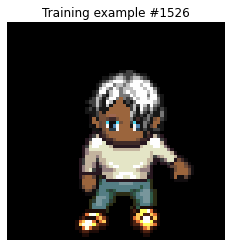

In [9]:
import random
random_image = random.randint(0, len(train_new))
plt.imshow(train_new[random_image])
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

In [10]:
class ConvEncoder(nn.Module):
  ###################### PSEUDOCODE ##########################
  # Encoder
  #   conv2d(3, 32, 3, 1, 1)
  #   relu()
  #   conv2d(32, 64, 3, 2, 1) # 16 x 16
  #   relu() 
  #   conv2d(64, 128, 3, 2, 1) # 8 x 8
  #   relu()
  #   conv2d(128, 256, 3, 2, 1) # 4 x 4
  #   relu()
  #   flatten()
  #   linear(4 * 4 * 256, 2 * latent_dim)

    def __init__(self,latent_size):
        super().__init__()
        self.latent_dim=latent_size
        self.convs = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  8,  8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),          # B,  64,  4,  4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1),            # B, 256,  1,  1
            nn.ReLU(True),
            
        )
            
        self.fc=nn.Linear(256, latent_size*2)            # B, z_dim*2

    def forward(self, x):
        out = self.convs(x)
        out=out.view(-1, 256*1*1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std

In [11]:
class ConvDecoder(nn.Module):
  ###################### PSEUDOCODE ##########################
  # Decoder
  #   linear(latent_dim, 4 * 4 * 128)
  #   relu()
  #   reshape(4, 4, 128)
  #   transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
  #   relu()
  #   transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
  #   relu()
  #   transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
  #   relu()
  #   conv2d(32, 3, 3, 1, 1)

    def __init__(self, latent_size):
        super().__init__()
        self.latent_dim=latent_size
        self.fc = nn.Linear(latent_size, 256)
        self.decoder = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, 4),      # B,  64,  4,  4
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 4, 2, 1), # B,  64,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),  # B, nc, 64, 64
        )
         
        

    def forward(self, z):
        batch=z.shape[0]
        out = self.fc(z)
        out = out.view(-1, 256, 1, 1)
        out=self.decoder(out)



        return out

In [12]:
class VanillaVAE(nn.Module):

  # Use ConvEncoder and ConvDecoder in init function
  # encoder = ConvEncoder
  # decoder = ConvDecoder
  def __init__(self,latent_size):
      super().__init__()
      self.latent_size=latent_size
      self.encoder=ConvEncoder(latent_size)
      self.decoder=ConvDecoder(latent_size)

  # implement loss function (ELBO)
  def loss(self,x):

    mu, log_std = self.encoder(x)
    z =  mu+torch.randn_like(mu) * log_std.exp() 
    x_recon = self.decoder(z)
    
  
    recon_loss = torch.mean(torch.sum(F.mse_loss(x, x_recon, reduction='none').view(x.shape[0], -1), dim=1).float())
    kl_loss =(torch.exp(2 * log_std) + mu ** 2) * 0.5  -log_std - 0.5
    kl_loss = torch.mean(torch.sum(kl_loss, dim=1).float())
    

    return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)




  # sampling function is already provided to you, you may wish to modify it if your model implementation is not compatible
  def sample(self, n):
      with torch.no_grad():
          z = torch.randn(n, self.latent_size).cuda()
          samples = torch.clamp(self.decoder(z), -1, 1)
      return samples.cpu().permute(0, 2, 3, 1).numpy()

In [13]:
def q2_a(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}, code is already provided for this
    - a (50, 32, 32, 3) numpy array of interpolations, code is already provided for this
    """

    model = VanillaVAE(32).cuda()
    train_data = (np.transpose(train_new, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_new, (0, 3, 1, 2)) / 255.).astype('float32')
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)

    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100) * 255.

    # The following lines are for creating reconstructions and interpolations from the test set
    # They should be working if you created your encoder, decoder correctly and named them encoder, decoder
    # Feel free to modify them if your model is not compatible with this piece of code
    x = next(iter(test_loader))[:50].cuda().float()
    with torch.no_grad():
        #x = rescale(x)
        z, _ = model.encoder(x)
        x_recon = torch.clamp(model.decoder(z), -1, 1)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 64, 64)
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

    x = next(iter(test_loader))[11:12].float().cuda()
    good_indices = [29,30,31]
    with torch.no_grad():
        #x = rescale(x)
        z, _ = model.encoder(x)
        z1 = torch.clone(z)
        out_interps = []
        for dim in good_indices:
          all_interps = []
          for alpha in np.linspace(0, 5, 10):
              z3 = torch.clone(z1)
              z3[:,dim] = z1[:,dim] + alpha
              interp = model.decoder(z3)
              all_interps.append(interp)
          all_interps = torch.stack(all_interps, dim=1).view(-1, 3, 64, 64)
          out_interps.append(all_interps)
    out_interps = torch.stack(out_interps, dim=0)
    out_interps = out_interps.view(-1, 3, 64, 64)
    out_interps = out_interps
    interps = out_interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    return train_losses, test_losses, samples, reconstructions, interps

Final -ELBO: 116.1945, Recon Loss: 101.7684, KL Loss: 14.4261


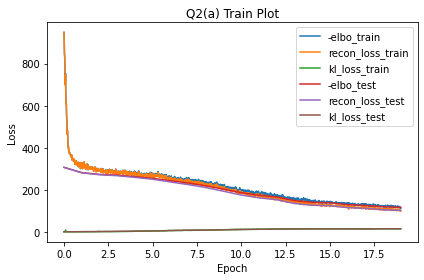

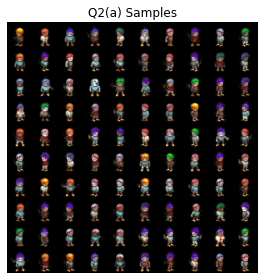

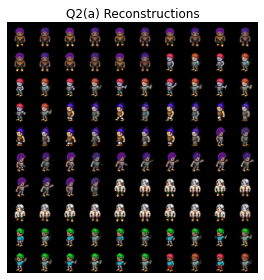

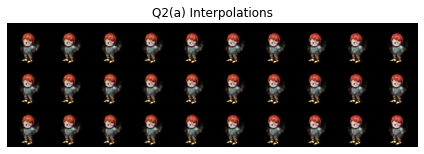

In [14]:
q2_save_results('a', q2_a)